# 🎯 06 - Validation Predictions for Submission

## 📑 Table of Contents
1. [🎯 Objectives](#-objectives)
2. [⚙️ Setup & Imports](#-setup--imports)
3. [📥 Load Best Model & Data](#-load-best-model--data)
4. [🔮 Make Predictions](#-make-predictions)
5. [📤 Generate Submission Files](#-generate-submission-files)
6. [📊 Submission History](#-submission-history)

---

## 🎯 Objectives
- Load the best performing model from previous experiments
- Generate predictions on the validation dataset
- Create submission files for all 3 attempts
- Track submission history and results



---

## ⚙️ 1. Setup & Imports


In [1]:
# Add project root to path
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime
import re

from sentence_transformers import SentenceTransformer

# Import your experiment tracker
import sys
sys.path.append('..')
from src.experiment_tracker import load_experiment_results, get_best_experiment

print("✅ Libraries imported!")
%matplotlib inline

✅ Libraries imported!



---

## 📥 2. Load Best Model & Data


In [2]:
print("📊 Loading best model from experiment tracker...")

# Load all experiment results
all_results = load_experiment_results()

if all_results.empty:
    raise ValueError("❌ No experiment results found! Run some experiments first.")

# Find the best experiment based on F1 score (primary metric)
best_experiment = get_best_experiment(all_results, 'f1_score')

print("🏆 Best Experiment Found:")
print("=" * 50)
for key, value in best_experiment.items():
    print(f"{key:20}: {value}")

# Extract information from the best experiment
experiment_type = best_experiment['experiment_type']
model_name = best_experiment['model_name']
preprocessing_strategy = best_experiment['preprocessing']
features_notes = best_experiment.get('notes', '')
training_f1 = best_experiment['f1_score']

# Extract features from notes (assuming format: "Features: ['feature1', 'feature2']")
features = []
if 'Features:' in features_notes:
    features_str = features_notes.split('Features: ')[1].strip("[]").replace("'", "")
    features = [feature.strip() for feature in features_str.split(",")]

print(f"\n📋 Best Model Configuration:")
print(f"   Model: {model_name}")
print(f"   Preprocessing: {preprocessing_strategy}")
print(f"   Features: {features}")
print(f"   Training F1: {training_f1:.4f}")

# Load the appropriate cleaned validation data
if preprocessing_strategy == 'basic':
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
    print("✅ Loaded basic cleaned validation data")
elif preprocessing_strategy == 'aggressive':
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_aggressive.csv')
    print("✅ Loaded aggressive cleaned validation data")
else:
    # Fallback to basic if unknown
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
    print("⚠️  Unknown preprocessing strategy, using basic cleaned data")

# Load original validation data for the final output format
original_val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")

# Now we need to find the actual model file
# The model filename is based on the experiment ID pattern
experiment_id = best_experiment['experiment_id']
model_filename = f"../models/best_model_{model_name.lower().replace(' ', '_')}_{experiment_id.split('_')[-1]}.pkl"

# Try to find the model file
model_path = None
possible_patterns = [
    model_filename,
    f"../models/best_model_*.pkl",  # Fallback: any best model file
    f"../models/*{model_name.lower().replace(' ', '_')}*.pkl"  # Fallback: any file with model name
]

for pattern in possible_patterns:
    if pattern == model_filename and os.path.exists(pattern):
        model_path = pattern
        break
    else:
        # Try to find files matching the pattern
        import glob
        matching_files = glob.glob(pattern)
        if matching_files:
            model_path = matching_files[0]  # Take the first match
            break

if model_path and os.path.exists(model_path):
    print(f"✅ Found model file: {model_path}")
    best_model = joblib.load(model_path)
    print(f"✅ Loaded model: {type(best_model).__name__}")
else:
    print("❌ Model file not found automatically. Please specify the path manually.")
    print("💡 You may need to train a model first or check the models directory.")
    # You can add manual path specification here if needed
    raise FileNotFoundError("Model file not found")

📊 Loading best model from experiment tracker...
🏆 Best Experiment Found:
experiment_type     : sentence_transformers
model_name          : SVM
preprocessing       : aggressive
accuracy            : 0.955313556139692
precision           : 0.9496420636879784
recall              : 0.96175
f1_score            : 0.9556576822754936
roc_auc             : 0.9907214214088744
dataset             : fake_news
notes               : Features: ['clean_text']
experiment_id       : se_s_20250903_131104
timestamp           : 2025-09-03T13:11:04.602249

📋 Best Model Configuration:
   Model: SVM
   Preprocessing: aggressive
   Features: ['clean_text']
   Training F1: 0.9557
✅ Loaded aggressive cleaned validation data
✅ Loaded original validation data for output format: (4956, 5)
✅ Found model file: ../models/best_model_svm_20250902_192249.pkl
✅ Loaded model: SVC


In [4]:
# Add this to your validation notebook BEFORE predicting
print("🔍 Checking for data leakage...")

# Load original validation data for the final output format
original_df = pd.read_csv('../dataset/00_raw/data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")


# Compare training vs validation distributions
print("📊 Training vs Validation Comparison:")
print(f"Training shape: {original_df.shape}")
print(f"Validation shape: {original_val_df.shape}")

# Check subject distribution
print("\n📋 Subject distribution comparison:")
train_subjects = original_df['subject'].value_counts(normalize=True)
val_subjects = original_val_df['subject'].value_counts(normalize=True)
subject_comparison = pd.DataFrame({'Train': train_subjects, 'Validation': val_subjects})
print(subject_comparison)

# Check date range
print("\n📅 Date range comparison:")
print(f"Train dates: {original_df['date'].min()} to {original_df['date'].max()}")
print(f"Validation dates: {original_val_df['date'].min()} to {original_val_df['date'].max()}")

# Check label distribution (if any labels exist in validation)
if 'label' in original_val_df.columns:
    val_label_counts = original_val_df['label'].value_counts(normalize=True)
    print(f"\n🎯 Label distribution (validation):")
    print(val_label_counts)

🔍 Checking for data leakage...
✅ Loaded original validation data for output format: (4956, 5)
📊 Training vs Validation Comparison:
Training shape: (39942, 5)
Validation shape: (4956, 5)

📋 Subject distribution comparison:
                    Train  Validation
subject                              
Government News  0.039307         NaN
Middle-east           NaN    0.156981
News             0.226579         NaN
US_News               NaN    0.157990
left-news        0.062140    0.398910
politics         0.171273         NaN
politicsNews     0.282209         NaN
worldnews        0.218492    0.286118

📅 Date range comparison:
Train dates: 14-Feb-18 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Validation dates: Apr 1, 2015 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg

🎯 Label distribution (validation):
label
2    1.0
Name: proportion, dtype: float64


In [5]:
# Ensure EXACT same preprocessing for validation as training
print("🔄 Verifying preprocessing consistency...")

# Load the exact same preprocessing parameters used for training
from src.data_cleaning import aggressive_clean_text

# Apply the EXACT same cleaning function
original_val_df['clean_text'] = original_val_df['text'].apply(aggressive_clean_text)

# Verify the cleaning worked
print(f"Validation samples after cleaning:")
print(original_val_df['clean_text'].head(3))
print(f"Missing values: {original_val_df['clean_text'].isnull().sum()}")

🔄 Verifying preprocessing consistency...
Validation samples after cleaning:
0    london reuters british prime minister theresa ...
1    london reuters british counter terrorism polic...
2    wellington reuters south pacific island nation...
Name: clean_text, dtype: object
Missing values: 0



---

## 🔮 3. Make Predictions


In [3]:
print("\n🔮 Making predictions...")

# Load the same sentence transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Loaded sentence transformer model")

# Prepare the text data based on the features used in training
def combine_features_for_prediction(data, features):
    """Combine features for prediction based on training configuration"""
    if not features or len(features) == 0:
        # Default to clean_title if no features specified
        return data['clean_title'].fillna('').astype(str)
    elif len(features) == 1:
        return data[features[0]].fillna('').astype(str)
    else:
        combined = data[features].fillna('').astype(str)
        return combined.apply(lambda x: ' | '.join(x), axis=1)

print(f"📋 Using features: {features}")

# Prepare the text data
X_val_text = combine_features_for_prediction(val_df, features)

# Create embeddings
print("🔄 Creating embeddings for validation data...")
X_val_embeddings = sentence_model.encode(X_val_text.tolist(), show_progress_bar=True)
print(f"📊 Embeddings shape: {X_val_embeddings.shape}")

# Make predictions
print("🎯 Making predictions...")
val_predictions = best_model.predict(X_val_embeddings)
val_probabilities = best_model.predict_proba(X_val_embeddings)[:, 1]  # Probability of class 1

print(f"✅ Predictions completed: {len(val_predictions)} samples")

# Add predictions to the original validation dataframe (to preserve the original format)
original_val_df['label'] = val_predictions

print("📊 Prediction distribution:")
pred_counts = pd.Series(val_predictions).value_counts()
print(pred_counts)
print(f"Fake (0): {pred_counts.get(0, 0)}")
print(f"Real (1): {pred_counts.get(1, 0)}")


🔮 Making predictions...
✅ Loaded sentence transformer model
📋 Using features: ['clean_text']
🔄 Creating embeddings for validation data...


Batches:   0%|          | 0/155 [00:00<?, ?it/s]

📊 Embeddings shape: (4956, 384)
🎯 Making predictions...
✅ Predictions completed: 4956 samples
📊 Prediction distribution:
0    3041
1    1915
Name: count, dtype: int64
Fake (0): 3041
Real (1): 1915



---

## 📤 4. Generate Submission Files


In [4]:
print("\n📤 Generating submission file...")

# Get your initials (change this to your actual initials)
your_initials = "gfm"  # Change to your initials, e.g., "js" for John Smith

# Create submissions directory
submissions_dir = "../dataset/02_submissions"
os.makedirs(submissions_dir, exist_ok=True)

# Load submission history to determine next attempt number
history_file = os.path.join(submissions_dir, "submission_history.csv")

if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    next_attempt = history_df['attempt'].max() + 1
    print(f"📋 Previous attempts found: {len(history_df)}")
    print(f"   Last attempt: {history_df['attempt'].max()}")
else:
    history_df = pd.DataFrame()
    next_attempt = 1
    print("📋 No previous submissions found")

print(f"🎯 Preparing attempt {next_attempt}")

# Create filename according to the required format
filename = f"{your_initials}_{next_attempt}.csv"
filepath = os.path.join(submissions_dir, filename)

# Check if file already exists to avoid overwriting
if os.path.exists(filepath):
    print(f"⚠️  Warning: {filename} already exists!")
    overwrite = input("Do you want to overwrite it? (y/n): ")
    if overwrite.lower() != 'y':
        print("❌ Submission cancelled")
        # You might want to handle this differently based on your workflow
    else:
        print("✅ Will overwrite existing file")

# Save the predictions
original_val_df.to_csv(filepath, index=False)
print(f"✅ Saved attempt {next_attempt}: {filename}")

# Record this submission in history
submission_record = {
    'timestamp': datetime.datetime.now().isoformat(),
    'attempt': next_attempt,
    'filename': filename,
    'model': model_name,
    'preprocessing': preprocessing_strategy,
    'features': str(features),
    'prediction_count_0': pred_counts.get(0, 0),
    'prediction_count_1': pred_counts.get(1, 0),
    'training_f1': training_f1,
    'experiment_id': experiment_id,
    'submission_status': 'submitted',
    'teacher_feedback': ''  # To be filled later
}

# Update history file
if not history_df.empty:
    updated_history = pd.concat([history_df, pd.DataFrame([submission_record])], ignore_index=True)
else:
    updated_history = pd.DataFrame([submission_record])

updated_history.to_csv(history_file, index=False)
print(f"✅ Submission recorded in history: {history_file}")

# Display file info
file_size = os.path.getsize(filepath) / 1024  # Size in KB
print(f"📁 File size: {file_size:.1f} KB")
print(f"📊 Predictions: {pred_counts.get(0, 0)} Fake (0), {pred_counts.get(1, 0)} Real (1)")


📤 Generating submission file...
📋 No previous submissions found
🎯 Preparing attempt 1
✅ Saved attempt 1: gfm_1.csv
✅ Submission recorded in history: ../dataset/02_submissions/submission_history.csv
📁 File size: 15821.5 KB
📊 Predictions: 3041 Fake (0), 1915 Real (1)



---

## 📊 5. Submission History & Analysis



📊 Submission History & Feedback Tracking
📋 Your Submission History:


,attempt,timestamp,model,preprocessing,prediction_count_0,prediction_count_1,training_f1,submission_status,teacher_feedback
0,1,2025-09-03T15:07:07.014236,SVM,aggressive,3041,1915,0.955658,submitted,NaN



📈 Current Prediction Analysis:


,Class,Count,Percentage
0,Fake (0),3041,61.36
1,Real (1),1915,38.64


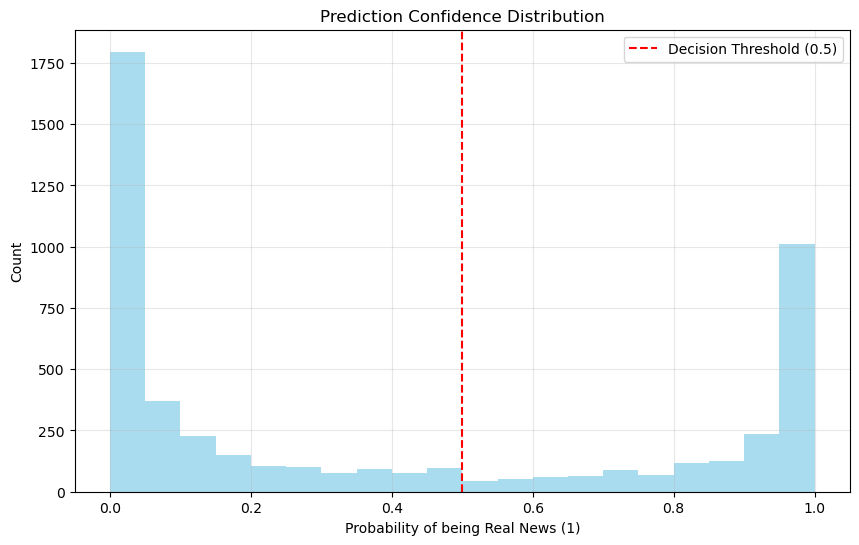

🎯 Next Steps:
1. 📤 Submit 'gfm_1.csv' to your teacher via Slack DM
2. 📝 You will receive accuracy, precision, recall, and F1 scores
3. 💡 Use the feedback to improve your model for next attempt
4. 🔄 Return here to generate your next submission when ready

📋 File ready for submission:
   📁 Filename: gfm_1.csv
   📊 Location: ../dataset/02_submissions/gfm_1.csv
   🎯 Attempt: 1
   🤖 Model: SVM
   🧹 Preprocessing: aggressive

⚠️  Important Notes:
1. Your submission files are ready in the '../submissions/' folder
2. Files follow the format: {initials}_{attempt}.csv
3. Send the files via DM to your teacher on Slack
4. You will receive accuracy, precision, recall, and F1 scores
5. Remember: F1 score is the primary ranking metric!
6. You have 3 attempts - use them wisely!

✅ Single submission file created successfully!
🚀 Good luck with your submission!


In [5]:
print("\n📊 Submission History & Feedback Tracking")
print("=" * 50)

# Display current submission history
if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    print("📋 Your Submission History:")
    
    # Display only essential columns for clarity
    display_cols = ['attempt', 'timestamp', 'model', 'preprocessing', 'prediction_count_0', 'prediction_count_1', 'training_f1', 'submission_status']
    if 'teacher_feedback' in history_df.columns:
        display_cols.append('teacher_feedback')
    
    display(history_df[display_cols])
else:
    print("No submission history found.")

# Analyze prediction distribution
print("\n📈 Current Prediction Analysis:")
prediction_analysis = pd.DataFrame({
    'Class': ['Fake (0)', 'Real (1)'],
    'Count': [pred_counts.get(0, 0), pred_counts.get(1, 0)],
    'Percentage': [
        pred_counts.get(0, 0) / len(val_predictions) * 100,
        pred_counts.get(1, 0) / len(val_predictions) * 100
    ]
})
prediction_analysis['Percentage'] = prediction_analysis['Percentage'].round(2)

display(prediction_analysis)

# Show confidence distribution if available
if val_probabilities is not None:
    plt.figure(figsize=(10, 6))
    plt.hist(val_probabilities, bins=20, alpha=0.7, color='skyblue')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Probability of being Real News (1)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

print("🎯 Next Steps:")
print("=" * 50)
print(f"1. 📤 Submit '{filename}' to your teacher via Slack DM")
print("2. 📝 You will receive accuracy, precision, recall, and F1 scores")
print("3. 💡 Use the feedback to improve your model for next attempt")
print("4. 🔄 Return here to generate your next submission when ready")

print(f"\n📋 File ready for submission:")
print(f"   📁 Filename: {filename}")
print(f"   📊 Location: {filepath}")
print(f"   🎯 Attempt: {next_attempt}")
print(f"   🤖 Model: {model_name}")
print(f"   🧹 Preprocessing: {preprocessing_strategy}")

print("\n⚠️  Important Notes:")
print("=" * 50)
print("1. Your submission files are ready in the '../submissions/' folder")
print("2. Files follow the format: {initials}_{attempt}.csv")
print("3. Send the files via DM to your teacher on Slack")
print("4. You will receive accuracy, precision, recall, and F1 scores")
print("5. Remember: F1 score is the primary ranking metric!")
print("6. You have 3 attempts - use them wisely!")


print("\n✅ Single submission file created successfully!")
print("🚀 Good luck with your submission!")

## 📝 6. Feedback Integration Helper (For Future Use)

In [6]:
# This cell is for when you receive feedback from your teacher
print("\n📝 Feedback Integration Helper")
print("=" * 50)
print("When you receive feedback from your teacher, you can use this section to record it.")

if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    
    # Show latest submission that might need feedback
    latest_submission = history_df[history_df['submission_status'] == 'submitted'].tail(1)
    
    if not latest_submission.empty:
        latest_attempt = latest_submission['attempt'].iloc[0]
        print(f"📋 Latest submission awaiting feedback: Attempt {latest_attempt}")
        
        # You can manually add feedback here or update the CSV directly
        print("To add feedback, you can:")
        print("1. Open the submission history CSV file")
        print("2. Find your attempt and add the feedback in the 'teacher_feedback' column")
        print("3. Update the 'submission_status' to 'reviewed'")
        
        # Example of how to update programmatically (uncomment and modify as needed)
        """
        # Uncomment and modify these lines when you have feedback
        feedback = "Accuracy: 0.92, Precision: 0.91, Recall: 0.93, F1: 0.92"
        history_df.loc[history_df['attempt'] == latest_attempt, 'teacher_feedback'] = feedback
        history_df.loc[history_df['attempt'] == latest_attempt, 'submission_status'] = 'reviewed'
        history_df.to_csv(history_file, index=False)
        print("✅ Feedback recorded!")
        """
    else:
        print("No submissions awaiting feedback")
else:
    print("No submission history found")

print("\n💡 Tips for using feedback:")
print("• Analyze which examples your model got wrong")
print("• Consider adjusting your preprocessing strategy")
print("• Try different feature combinations")
print("• Experiment with different models")
print("• Remember: F1 score is the primary metric!")

print("\n🔄 When you're ready for your next attempt:")
print("1. Improve your model based on feedback")
print("2. Run your experiments again")
print("3. Return to this notebook")
print("4. Run all cells to generate your next submission")


📝 Feedback Integration Helper
When you receive feedback from your teacher, you can use this section to record it.
📋 Latest submission awaiting feedback: Attempt 1
To add feedback, you can:
1. Open the submission history CSV file
2. Find your attempt and add the feedback in the 'teacher_feedback' column
3. Update the 'submission_status' to 'reviewed'

💡 Tips for using feedback:
• Analyze which examples your model got wrong
• Consider adjusting your preprocessing strategy
• Try different feature combinations
• Experiment with different models
• Remember: F1 score is the primary metric!

🔄 When you're ready for your next attempt:
1. Improve your model based on feedback
2. Run your experiments again
3. Return to this notebook
4. Run all cells to generate your next submission


## 🎯 7. Quick Submission Checklist

In [7]:
print("\n✅ Quick Submission Checklist")
print("=" * 50)

checklist_items = [
    ("File follows naming format {initials}_{attempt}.csv", filename == f"{your_initials}_{next_attempt}.csv"),
    ("File contains only original columns", set(original_val_df.columns) == {'label', 'title', 'text', 'subject', 'date'}),
    ("All '2' labels replaced with predictions", original_val_df['label'].isin([0, 1]).all()),
    ("File saved in submissions folder", os.path.exists(filepath)),
    ("Submission recorded in history", os.path.exists(history_file)),
]

all_checks_passed = True

for item, check_passed in checklist_items:
    status = "✅" if check_passed else "❌"
    print(f"{status} {item}")
    if not check_passed:
        all_checks_passed = False

if all_checks_passed:
    print("\n🎉 All checks passed! Your file is ready for submission.")
    print(f"📤 Send '{filename}' to your teacher via Slack DM")
else:
    print("\n⚠️  Some checks failed. Please review your submission file.")

print(f"\n📁 Submission file: {filepath}")
print(f"📋 Attempt number: {next_attempt}")
print(f"📊 Total submissions so far: {len(history_df) if os.path.exists(history_file) else 0}")


✅ Quick Submission Checklist
✅ File follows naming format {initials}_{attempt}.csv
✅ File contains only original columns
✅ All '2' labels replaced with predictions
✅ File saved in submissions folder
✅ Submission recorded in history

🎉 All checks passed! Your file is ready for submission.
📤 Send 'gfm_1.csv' to your teacher via Slack DM

📁 Submission file: ../dataset/02_submissions/gfm_1.csv
📋 Attempt number: 1
📊 Total submissions so far: 1



---

## 📁 Expected File Structure

After running this notebook, you'll have:

```
your_project_folder/
├── submissions/
│   ├── nm_1.csv          # Your first attempt
│   ├── nm_2.csv          # Your second attempt  
│   ├── nm_3.csv          # Your third attempt
│   └── submission_history.csv  # Tracks all your submissions
├── models/
│   ├── best_model_svm_20231115_1430.pkl      # Your best model
│   └── best_model_metadata_20231115_1430.csv # Model metadata
└── data/
    ├── 00_raw/
    │   └── validation_data.csv          # Original validation data
    └── 01_interim/
        ├── cleaned_validation_basic.csv      # Cleaned data (basic)
        └── cleaned_validation_aggressive.csv # Cleaned data (aggressive)
```

## 🎯 How to Use This Notebook

1. **Update the paths** to your actual best model and metadata files
2. **Change `your_initials`** to your actual initials
3. **Run the entire notebook** to generate all 3 submission files
4. **Submit the files** to your teacher via Slack DM
5. **Update the notebook** for subsequent attempts with improved models

## 💡 Pro Tips

1. **First attempt**: Use your current best model to get a baseline
2. **Second attempt**: Improve based on teacher feedback from attempt 1
3. **Third attempt**: Final optimization based on both previous attempts' feedback
4. **Keep track** of what changes you make between attempts in the submission history
